# Freshwater Samples
## April 24, 2024

In [324]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns
import pyleoclim as pyleo
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Complete [Sample data](https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=1075059730)

In [102]:
df = pd.read_csv('Samples.csv')

In [103]:
df = df[df['Complete'] == True]

In [104]:
df = df.reset_index()
df

,index,Sample,Time,Location,Category,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Lab Salinity,In Situ Temperature,in situ salinity,in situ pH,lab pH,lab pH temp,Salinity,Complete,notes
0,0,PLT 4/28/22 A,4/28/22 7:30,PLT,Bay,surface,20.9,2078.825,22.0,1931.63783,29.480,10.400,NaN,NaN,NaN,NaN,29.4800,True,NaN
1,1,PLT 4/28/22 B,4/28/22 7:30,PLT,Bay,surface,20.9,2078.410,22.0,1931.62999,29.480,10.400,NaN,NaN,NaN,NaN,29.4800,True,NaN
2,2,PLT 5/9/22 surf A,5/9/22 7:30,PLT,Bay,surface,20.3,2075.470,22.0,1985.40452,29.420,10.970,NaN,NaN,NaN,NaN,29.4200,True,NaN
3,3,PLT 5/9/22 surf B,5/9/22 7:30,PLT,Bay,surface,20.3,2076.780,22.0,1955.71939,29.420,10.970,NaN,NaN,NaN,NaN,29.4200,True,NaN
4,4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,Bay,bottom,20.9,2138.395,22.0,1978.53868,30.620,15.740,NaN,NaN,NaN,NaN,30.6200,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,278,AC EGWW S,1/25/24 9:40 AM,EGWW,Wastewater,surface,21.0,737.230,21.0,772.80000,7.611,3.439,26.66,8.22,NaN,NaN,7.6110,True,NaN
154,280,AL Palmer B,1/25/24 1:05 PM,Palmer River,Fresh,bottom,21.0,283.010,21.0,434.80000,0.749,1.386,0.55,7.58,NaN,NaN,0.6495,True,NaN
155,282,AI 10 mile S,1/25/24 12:15 PM,Ten Mile River,Fresh,surface,21.0,471.075,21.0,636.40000,0.276,4.375,0.26,7.56,NaN,NaN,0.2680,True,NaN
156,294,NB PLT 332,1/15/24 7:30 AM,PLT,Bay,bottom,20.8,2005.065,21.1,1902.70000,28.550,4.900,NaN,NaN,NaN,NaN,28.5500,True,"cold, lots of snow, rain and flooding in past ..."


## Convert to `datetime` object ad convert timezone to UTC

In [105]:
for ind in df.index:
    AMPM = df['Time'][ind].endswith('M')
    if AMPM:
        if "202" in df['Time'][ind]:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%Y %H:%M %p')
        else:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%y %H:%M %p')
    elif not ":" in df['Time'][ind] and not AMPM:
        if "202" in df['Time'][ind]:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%Y')
        else:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%y') 
    else:
        if "202" in df['Time'][ind]:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%Y %H:%M')
        else:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%y %H:%M')
            
# Eastern time daylights savings is 4 hours behind UTC
# Eastern standard time is 5 hours behind UTC
daylight_start_date24 = pd.Timestamp(datetime(2024, 3, 10, 0, 0,0))     # Begin 2024 Daylight Time
daylight_end_date24 = pd.Timestamp(datetime(2024, 11, 3, 0, 0,0))       # End 2024 Daylight Time
daylight_start_date23 = pd.Timestamp(datetime(2023, 3, 12, 0, 0,0))     # Begin 2023 Daylight Time
daylight_end_date23 = pd.Timestamp(datetime(2023, 11, 5, 0, 0,0))       # End 2023 Daylight Time
daylight_start_date22 = pd.Timestamp(datetime(2022, 3, 13, 0, 0,0))     # Begin 2022 Daylight Time
daylight_end_date22 = pd.Timestamp(datetime(2022, 11, 6, 0, 0,0))       # End 2022 Daylight Time

# For each index in dataframe df...
for ind in df.index:
    if (df['Time'][ind] >= daylight_start_date24) & (df['Time'][ind] < daylight_end_date24):
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 4)
    elif (df['Time'][ind] >= daylight_start_date23) & (df['Time'][ind] < daylight_end_date23):
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 4)
    elif (df['Time'][ind] >= daylight_start_date22) & (df['Time'][ind] < daylight_end_date22):
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 4)
    else:
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 5)

## Carb calculations

In [106]:
# # CONVERT FROM uM TO umol/kg------------------------------------------------------------------------------
# Pressure
df['P'] = 0

# Density
df['rho_DIC'] = gsw.rho(df['Salinity'], df['DIC Temp (degC)'], df['P'])
df['rho_TA'] = gsw.rho(df['Salinity'], df['TA Temp (degC)'], df['P'])

# Converted DIC and TA
df['DIC (umol/kg)'] = df['DIC (uM)']/df['rho_DIC']/0.001
df['TA (umol/kg)'] = df['TA (uM)']/df['rho_TA']/0.001
    
# Calculate pH with PyCO2SYS
results = pyco2.sys(par1=df['TA (umol/kg)'],par2=df['DIC (umol/kg)'],par1_type=1,par2_type=2,
                    salinity = df['Salinity'], temperature = df['In Situ Temperature'])
df['pH'] = results['pH']
df['pCO2'] = results['pCO2']
df['fCO2'] = results['fCO2']
df['Ω'] = results['saturation_aragonite']
dfout = df[['Sample', 'Time', 'Location', 'depth', 'Category', 'Salinity', 'In Situ Temperature', 'DIC (umol/kg)', 'TA (umol/kg)', 
            'pH','pCO2','fCO2','Ω']]
dfout

,Sample,Time,Location,depth,Category,Salinity,In Situ Temperature,DIC (umol/kg),TA (umol/kg),pH,pCO2,fCO2,Ω
0,PLT 4/28/22 A,2022-04-28 11:30:00,PLT,surface,Bay,29.4800,10.400,1893.800902,2037.524946,8.052270,369.496477,368.081301,1.639099
1,PLT 4/28/22 B,2022-04-28 11:30:00,PLT,surface,Bay,29.4800,10.400,1893.793216,2037.118191,8.051216,370.434636,369.015867,1.635310
2,PLT 5/9/22 surf A,2022-05-09 11:30:00,PLT,surface,Bay,29.4200,10.970,1946.599760,2034.019064,7.872654,583.645244,581.426259,1.157688
3,PLT 5/9/22 surf B,2022-05-09 11:30:00,PLT,surface,Bay,29.4200,10.970,1917.494827,2035.302901,7.969078,457.271877,455.533357,1.414052
4,PLT 5/22/22 bottom,2022-05-22 11:30:00,PLT,bottom,Bay,30.6200,15.740,1938.168218,2094.161828,7.976161,455.715306,454.085023,1.822445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,AC EGWW S,2024-01-25 14:40:00,EGWW,surface,Wastewater,7.6110,3.439,769.781159,734.350109,7.512775,654.982022,652.233667,0.068877
154,AL Palmer B,2024-01-25 06:05:00,Palmer River,bottom,Fresh,0.6495,1.386,435.363064,283.376496,6.658579,2085.665124,2076.670123,0.001542
155,AI 10 mile S,2024-01-25 17:15:00,Ten Mile River,surface,Fresh,0.2680,4.375,637.407829,471.821014,6.797019,2544.778746,2534.232558,0.002517
156,NB PLT 332,2024-01-15 12:30:00,PLT,bottom,Bay,28.5500,4.900,1866.265219,1966.520859,8.035667,381.182456,379.613684,1.191970


## Plot
### pH

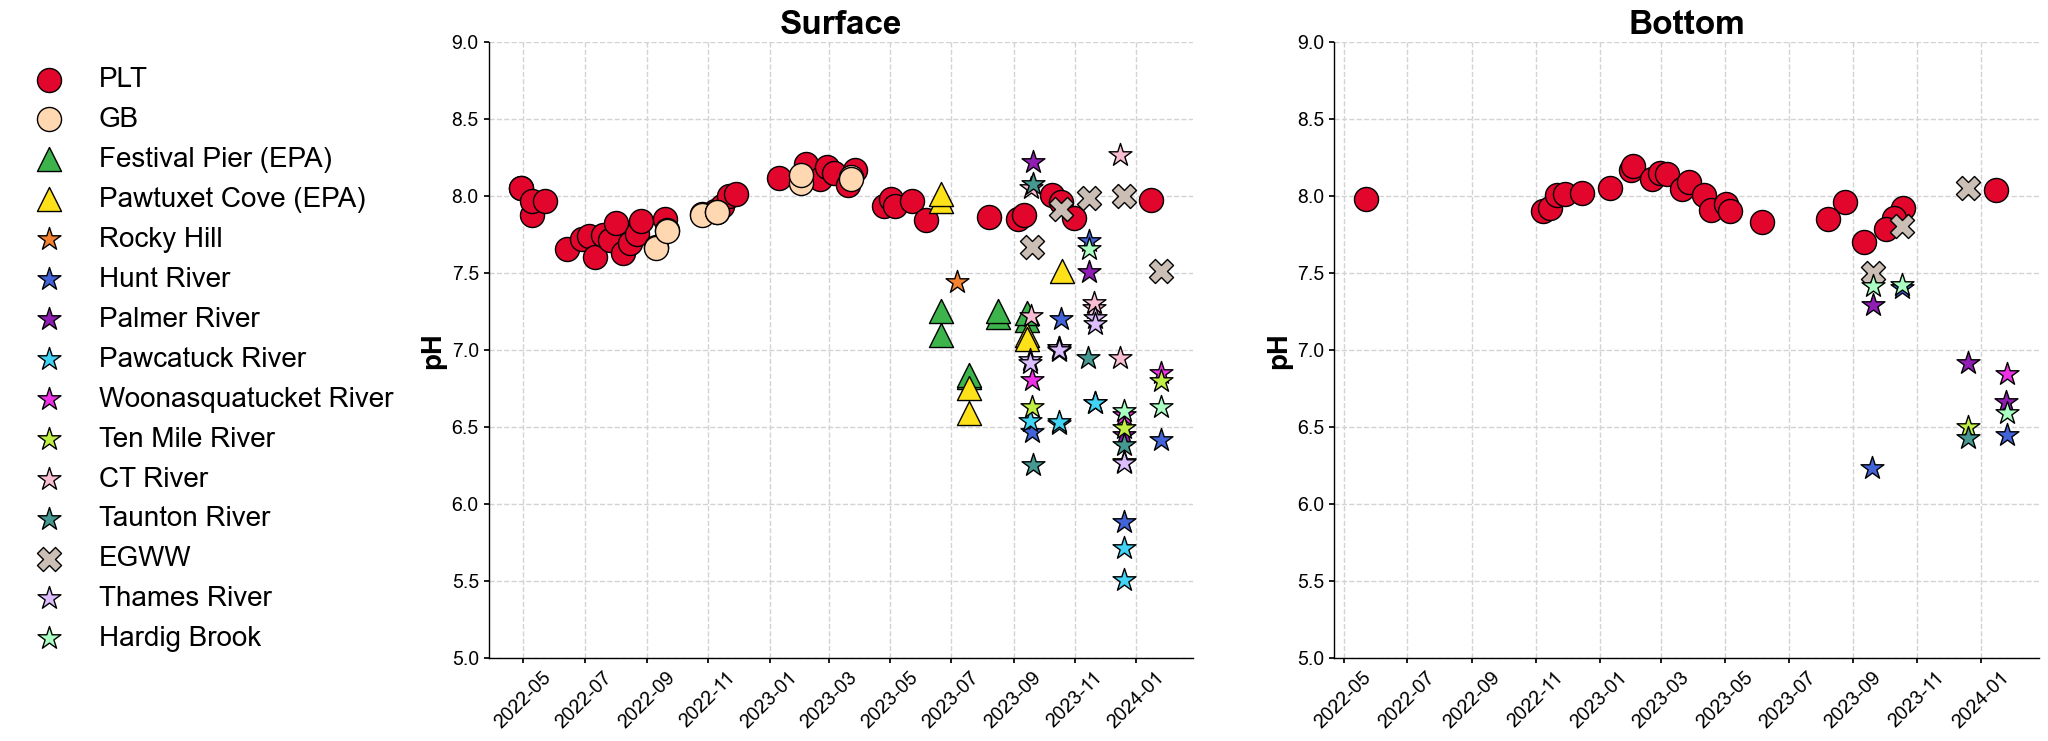

In [194]:


colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'maroon': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'olive': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot
markers = {'Bay': 'o', 'Fresh (EPA)': '^', 'Fresh': '*', 'Wastewater': 'X'}


fig, axarr = plt.subplots(ncols = 2, figsize = [20,8])
axarr = axarr.flatten()


for name in dfout['Location'].unique():
    dat = dfout[dfout['Location'] == name]
    surf = dat[dat['depth'] == 'surface']
    bott = dat[dat['depth'] == 'bottom']
    cat = dat['Category'].unique()
    axarr[0].scatter(surf['Time'],surf['pH'], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    axarr[1].scatter(bott['Time'],bott['pH'], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    
axarr[0].legend(bbox_to_anchor=(-0.1, 1), fontsize = 20)

for ax in axarr:
    # ax.xaxis.set_major_formatter(dtFmt) 
    ax.set_ylabel('pH', fontsize = 20, fontweight = 'bold')
    ax.set_ylim([5,9])
    ax.tick_params('x', labelsize = 14, labelrotation = 45)
    ax.tick_params('y', labelsize = 14)
axarr[0].set_title('Surface', fontsize = 24, fontweight = 'bold')
axarr[1].set_title('Bottom', fontsize = 24, fontweight = 'bold')
fig.savefig('pH.png', bbox_inches='tight')

### DIC

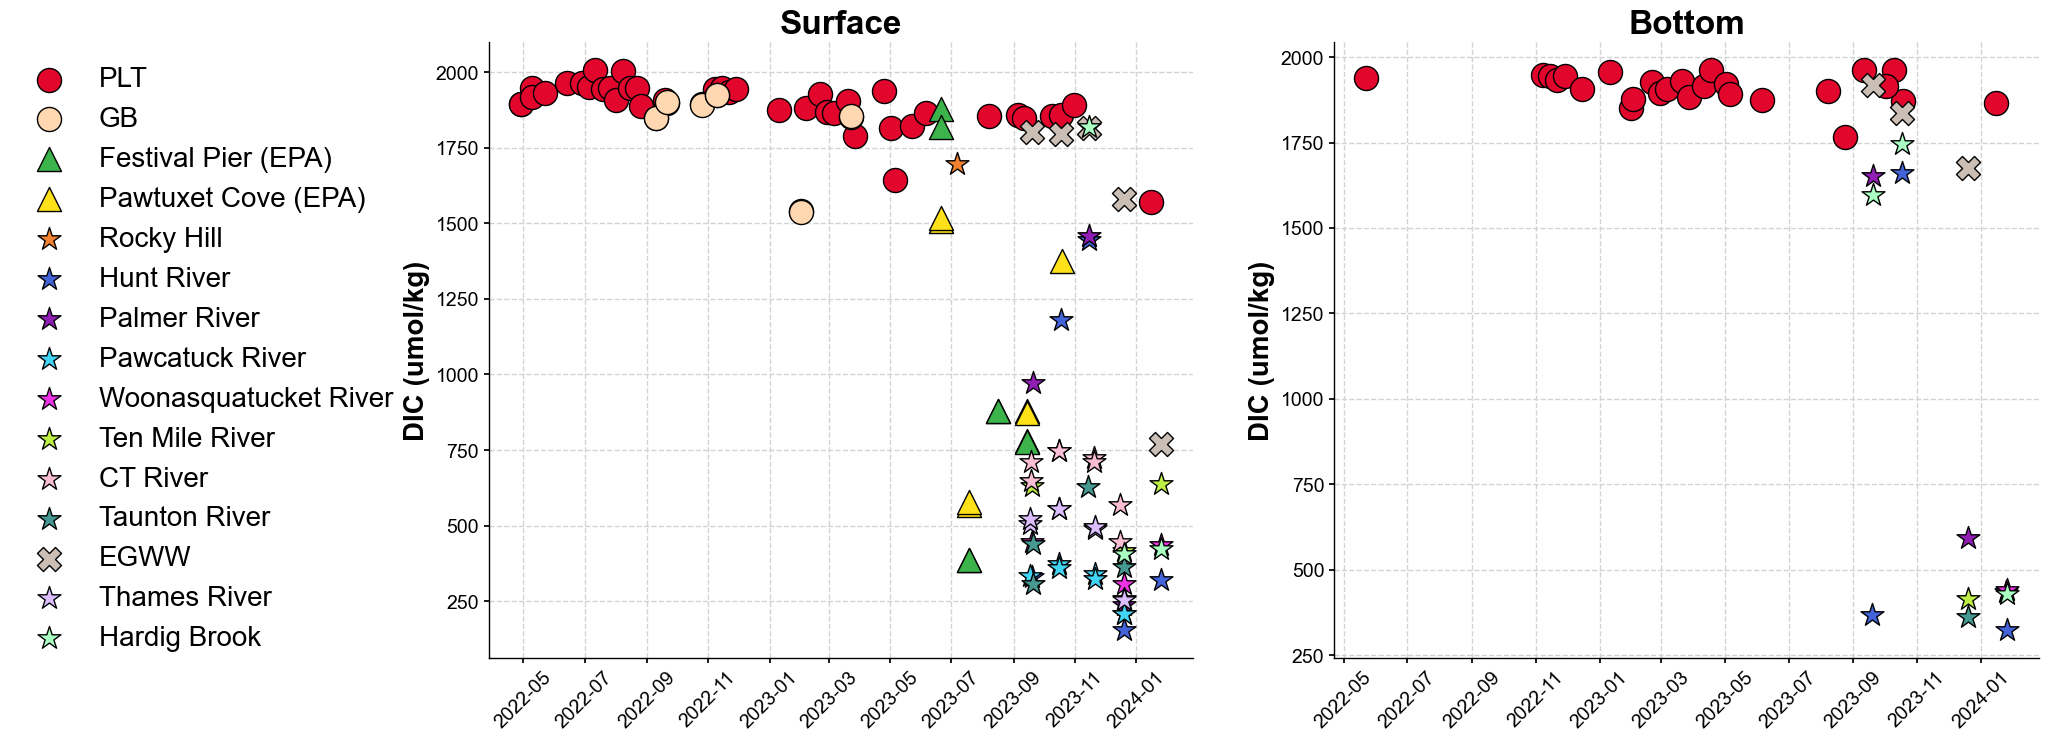

In [195]:


colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'maroon': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'olive': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot
markers = {'Bay': 'o', 'Fresh (EPA)': '^', 'Fresh': '*', 'Wastewater': 'X'}


fig, axarr = plt.subplots(ncols = 2, figsize = [20,8])
axarr = axarr.flatten()
var = 'DIC (umol/kg)'

for name in dfout['Location'].unique():
    dat = dfout[dfout['Location'] == name]
    surf = dat[dat['depth'] == 'surface']
    bott = dat[dat['depth'] == 'bottom']
    cat = dat['Category'].unique()
    axarr[0].scatter(surf['Time'],surf[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    axarr[1].scatter(bott['Time'],bott[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    
axarr[0].legend(bbox_to_anchor=(-0.1, 1), fontsize = 20)

for ax in axarr:
    # ax.xaxis.set_major_formatter(dtFmt) 
    ax.set_ylabel(var, fontsize = 20, fontweight = 'bold')
    # ax.set_ylim([5,9])
    ax.tick_params('x', labelsize = 14, labelrotation = 45)
    ax.tick_params('y', labelsize = 14)
axarr[0].set_title('Surface', fontsize = 24, fontweight = 'bold')
axarr[1].set_title('Bottom', fontsize = 24, fontweight = 'bold')
fig.savefig('DIC.png', bbox_inches='tight')

### TA

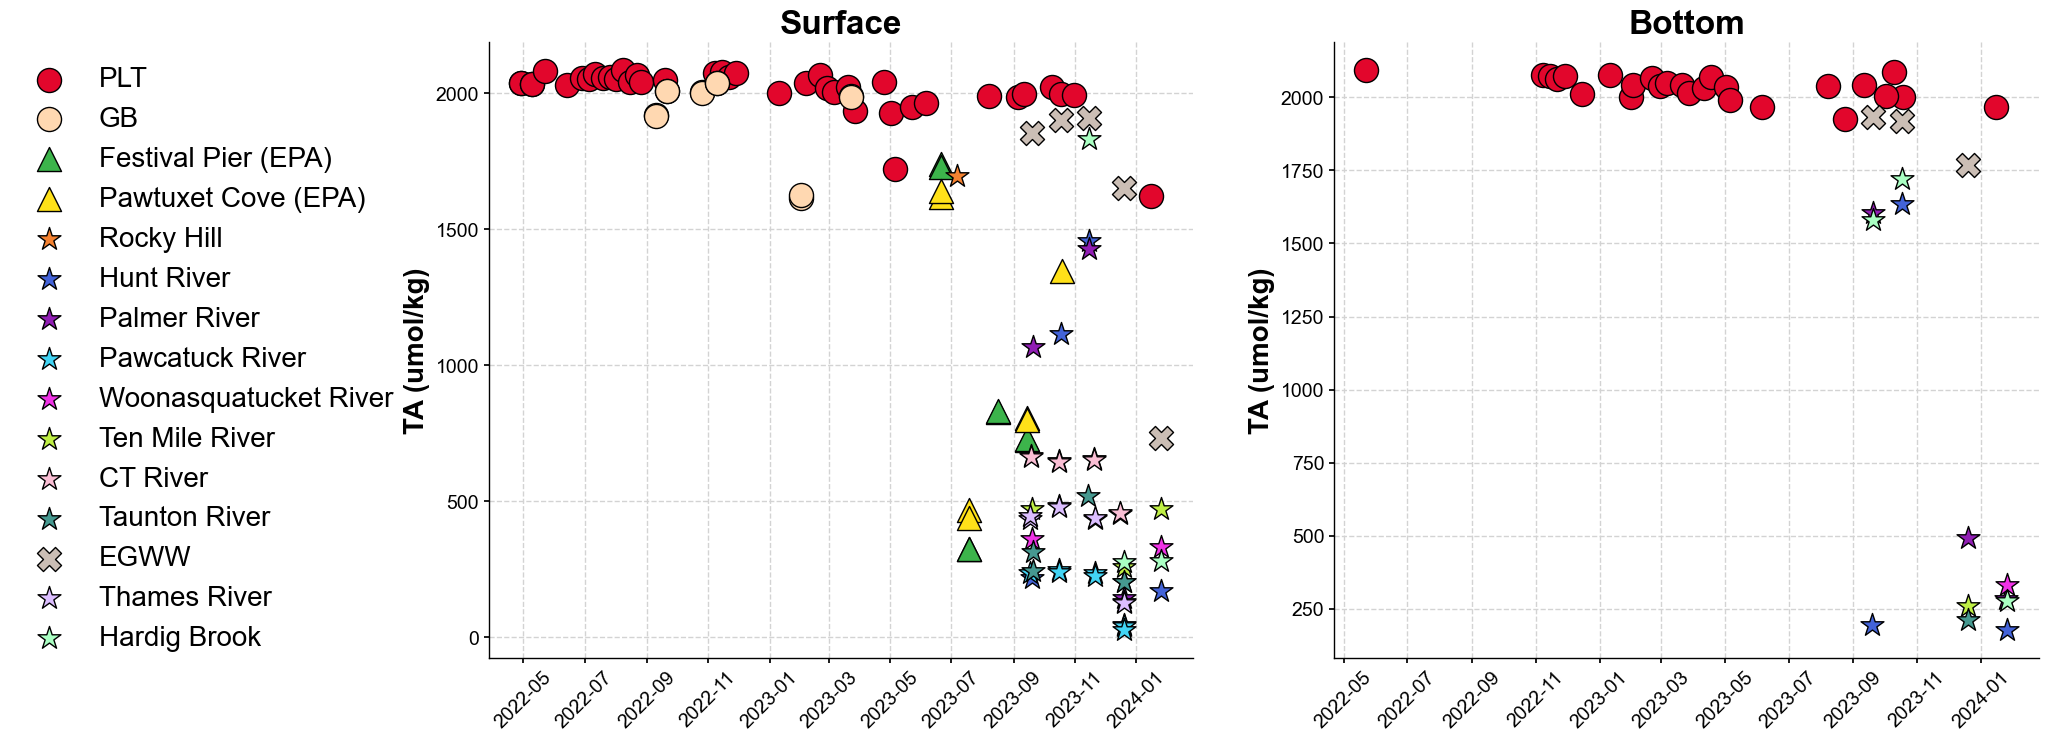

In [196]:


colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'maroon': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'olive': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot
markers = {'Bay': 'o', 'Fresh (EPA)': '^', 'Fresh': '*', 'Wastewater': 'X'}


fig, axarr = plt.subplots(ncols = 2, figsize = [20,8])
axarr = axarr.flatten()
var = 'TA (umol/kg)'

for name in dfout['Location'].unique():
    dat = dfout[dfout['Location'] == name]
    surf = dat[dat['depth'] == 'surface']
    bott = dat[dat['depth'] == 'bottom']
    cat = dat['Category'].unique()
    axarr[0].scatter(surf['Time'],surf[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    axarr[1].scatter(bott['Time'],bott[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    
axarr[0].legend(bbox_to_anchor=(-0.1, 1), fontsize = 20)

for ax in axarr:
    # ax.xaxis.set_major_formatter(dtFmt) 
    ax.set_ylabel(var, fontsize = 20, fontweight = 'bold')
    # ax.set_ylim([5,9])
    ax.tick_params('x', labelsize = 14, labelrotation = 45)
    ax.tick_params('y', labelsize = 14)
axarr[0].set_title('Surface', fontsize = 24, fontweight = 'bold')
axarr[1].set_title('Bottom', fontsize = 24, fontweight = 'bold')
fig.savefig('TA.png', bbox_inches='tight')

# Wastewater samples

In [186]:
df = pd.read_csv('Samples.csv')
df = df[df['Category'] == 'Wastewater']
df = df.reset_index()

## Drop any without TA, DIC, or S

In [187]:
for ind in df.index:
    # if TA or DIC or salinity or in situ tempertuare at that index is Nan/empty...
    if math.isnan(df['TA (uM)'][ind]) or math.isnan(df['DIC (uM)'][ind]) or math.isnan(df['Salinity'][ind]):                                                                      
        # Drop that index
        df = df.drop(ind)

## Convert time

In [188]:
for ind in df.index:
    AMPM = df['Time'][ind].endswith('M')
    if AMPM:
        if "202" in df['Time'][ind]:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%Y %H:%M %p')
        else:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%y %H:%M %p')
    elif not ":" in df['Time'][ind] and not AMPM:
        if "202" in df['Time'][ind]:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%Y')
        else:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%y') 
    else:
        if "202" in df['Time'][ind]:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%Y %H:%M')
        else:
            df['Time'][ind] = datetime.strptime(df['Time'][ind], '%m/%d/%y %H:%M')
            
# Eastern time daylights savings is 4 hours behind UTC
# Eastern standard time is 5 hours behind UTC
daylight_start_date24 = pd.Timestamp(datetime(2024, 3, 10, 0, 0,0))     # Begin 2024 Daylight Time
daylight_end_date24 = pd.Timestamp(datetime(2024, 11, 3, 0, 0,0))       # End 2024 Daylight Time
daylight_start_date23 = pd.Timestamp(datetime(2023, 3, 12, 0, 0,0))     # Begin 2023 Daylight Time
daylight_end_date23 = pd.Timestamp(datetime(2023, 11, 5, 0, 0,0))       # End 2023 Daylight Time
daylight_start_date22 = pd.Timestamp(datetime(2022, 3, 13, 0, 0,0))     # Begin 2022 Daylight Time
daylight_end_date22 = pd.Timestamp(datetime(2022, 11, 6, 0, 0,0))       # End 2022 Daylight Time

# For each index in dataframe df...
for ind in df.index:
    if (df['Time'][ind] >= daylight_start_date24) & (df['Time'][ind] < daylight_end_date24):
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 4)
    elif (df['Time'][ind] >= daylight_start_date23) & (df['Time'][ind] < daylight_end_date23):
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 4)
    elif (df['Time'][ind] >= daylight_start_date22) & (df['Time'][ind] < daylight_end_date22):
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 4)
    else:
        df['Time'][ind] = df['Time'][ind] + timedelta(hours = 5)

In [189]:
# # CONVERT FROM uM TO umol/kg------------------------------------------------------------------------------
# Pressure
df['P'] = 0
df['T'] = 15

# Density
df['rho_DIC'] = gsw.rho(df['Salinity'], df['DIC Temp (degC)'], df['P'])
df['rho_TA'] = gsw.rho(df['Salinity'], df['TA Temp (degC)'], df['P'])

# Converted DIC and TA
df['DIC (umol/kg)'] = df['DIC (uM)']/df['rho_DIC']/0.001
df['TA (umol/kg)'] = df['TA (uM)']/df['rho_TA']/0.001
    
# Calculate pH with PyCO2SYS
results = pyco2.sys(par1=df['TA (umol/kg)'],par2=df['DIC (umol/kg)'],par1_type=1,par2_type=2,
                    salinity = df['Salinity'], temperature = df['T'])
df['pH'] = results['pH']
df['pCO2'] = results['pCO2']
df['fCO2'] = results['fCO2']
df['Ω'] = results['saturation_aragonite']
dfwaste = df[['Sample', 'Time', 'Location', 'depth', 'Category', 'Salinity', 'In Situ Temperature', 'DIC (umol/kg)', 'TA (umol/kg)', 
            'pH','pCO2','fCO2','Ω']]
dfwaste

,Sample,Time,Location,depth,Category,Salinity,In Situ Temperature,DIC (umol/kg),TA (umol/kg),pH,pCO2,fCO2,Ω
0,EGWW 105,2023-09-19 12:41:00,EGWW,bottom,Wastewater,27.070,21.229,1916.894418,1933.597900,7.579430,1171.018470,1166.789842,0.659915
1,8 EGWW,2023-09-19 12:41:00,EGWW,surface,Wastewater,25.450,20.721,1800.508872,1853.822121,7.750091,749.787367,747.079834,0.879072
3,92 EGWW,2023-11-14 16:12:00,EGWW,surface,Wastewater,26.530,8.697,1815.548471,1911.086559,7.886810,543.151837,541.190478,1.238958
4,FP 10,2023-09-19 15:15:00,FP,surface,Wastewater,0.454,NaN,1057.845056,823.081466,6.742027,5206.304228,5187.503910,0.009239
5,FP 99,2023-09-19 15:15:00,FP,surface,Wastewater,0.456,NaN,828.108261,835.111596,7.989956,285.250948,284.220888,0.158947
6,FP 46,2023-10-17 11:30:00,FP,surface,Wastewater,0.875,NaN,1645.581318,1703.544748,8.251431,303.944232,302.846669,0.782777
7,FP 366,2023-10-17 11:30:00,FP,surface,Wastewater,0.833,NaN,1978.023965,1713.409343,6.997981,5950.355609,5928.868470,0.046651
8,BP 101,2023-09-19 14:00:00,BP,surface,Wastewater,0.200,NaN,594.983044,616.944016,8.271298,106.402104,106.017879,0.130080
9,BP 22,2023-09-19 14:00:00,BP,surface,Wastewater,0.204,NaN,563.329044,616.261091,8.625455,42.458807,42.305486,0.268758
10,BP188,2023-10-17 11:15:00,BP,surface,Wastewater,0.308,NaN,1148.103340,1166.908657,8.082174,320.055841,318.900098,0.216647


## Plot
### TA

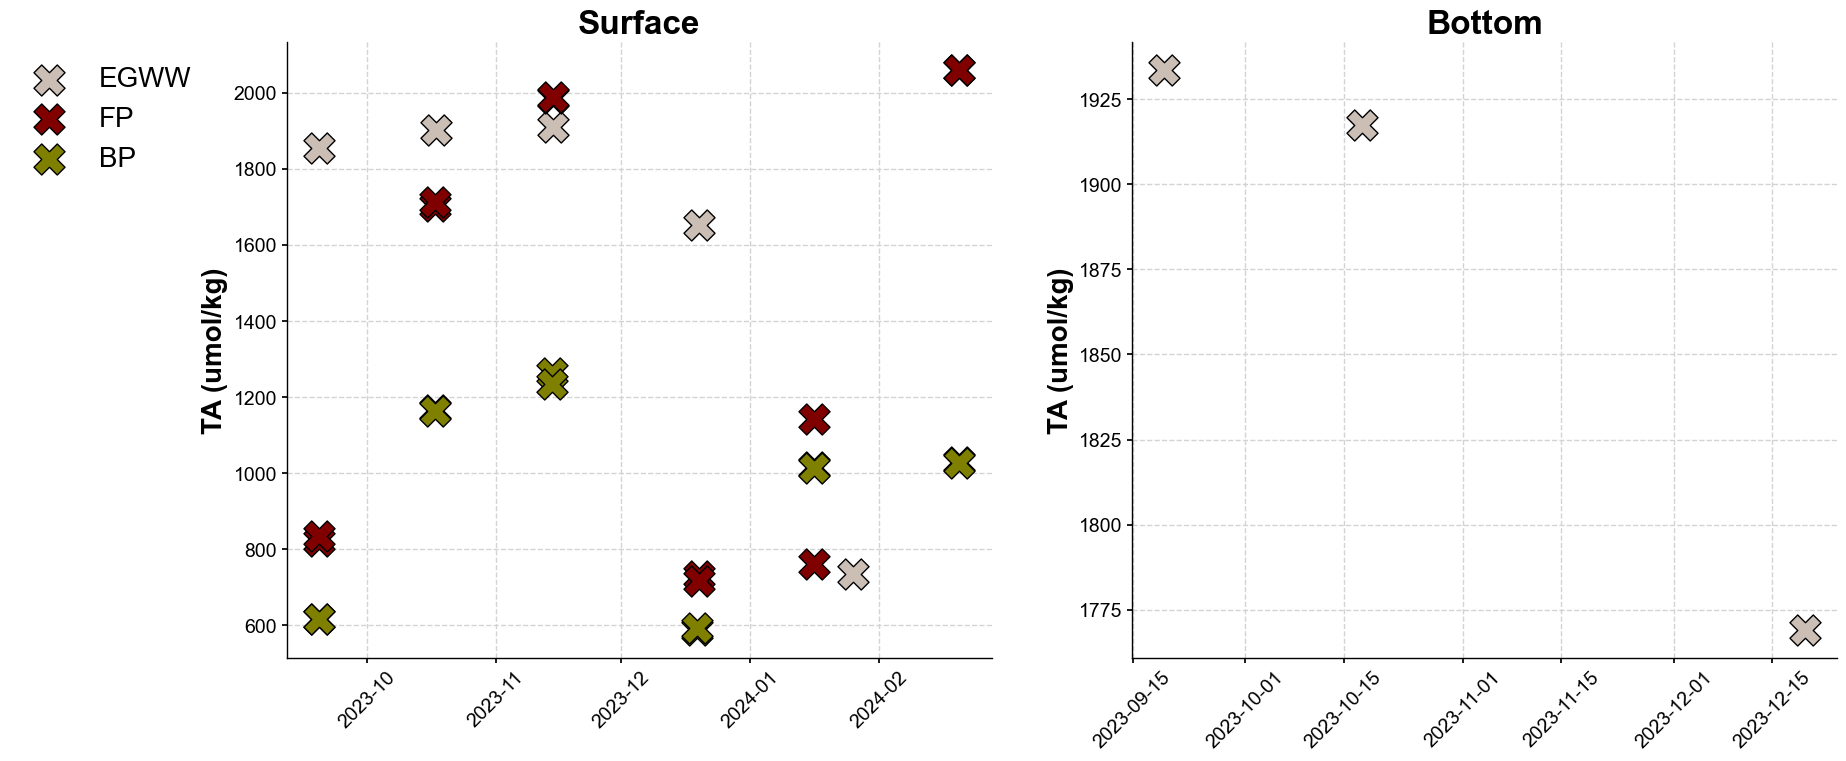

In [392]:


colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'FP': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'BP': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot
markers = {'Bay': 'o', 'Fresh (EPA)': '^', 'Fresh': '*', 'Wastewater': 'X'}


fig, axarr = plt.subplots(ncols = 2, figsize = [20,8])
axarr = axarr.flatten()
var = 'TA (umol/kg)'

for name in dfwaste['Location'].unique():
    dat = dfwaste[dfwaste['Location'] == name]
    surf = dat[dat['depth'] == 'surface']
    bott = dat[dat['depth'] == 'bottom']
    cat = dat['Category'].unique()
    axarr[0].scatter(surf['Time'],surf[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 500, label = name)
    axarr[1].scatter(bott['Time'],bott[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 500, label = name)
    
axarr[0].legend(bbox_to_anchor=(-0.1, 1), fontsize = 20)

for ax in axarr:
    # ax.xaxis.set_major_formatter(dtFmt) 
    ax.set_ylabel(var, fontsize = 20, fontweight = 'bold')
    # ax.set_ylim([5,9])
    ax.tick_params('x', labelsize = 14, labelrotation = 45)
    ax.tick_params('y', labelsize = 14)
axarr[0].set_title('Surface', fontsize = 24, fontweight = 'bold')
axarr[1].set_title('Bottom', fontsize = 24, fontweight = 'bold')
fig.savefig('TAwaste.png', bbox_inches='tight')

### pH

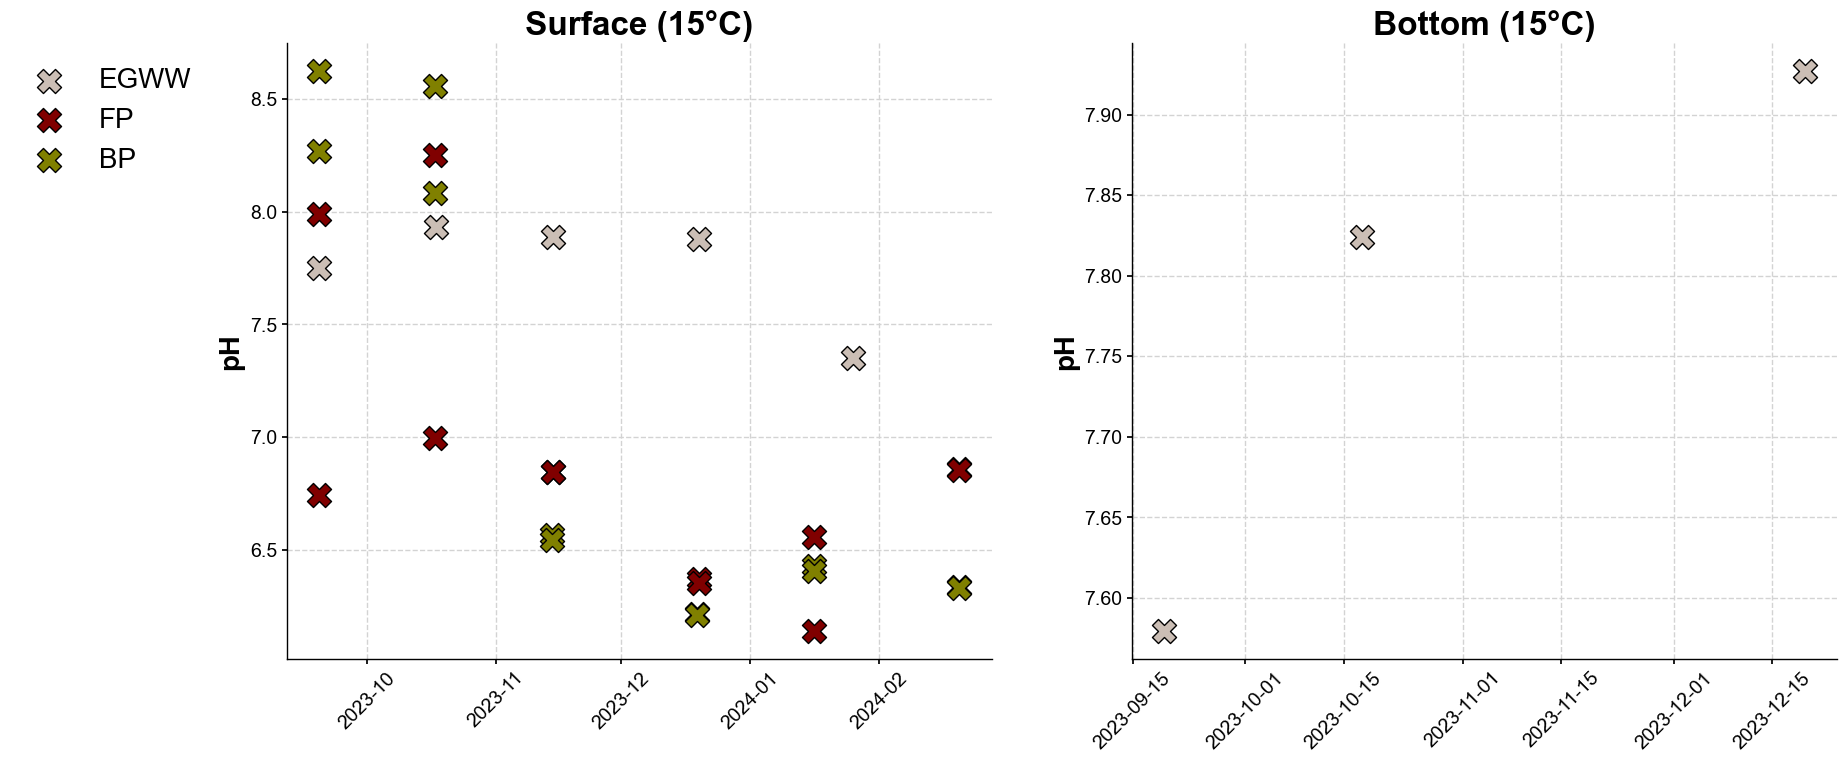

In [198]:


colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'FP': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'BP': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot
markers = {'Bay': 'o', 'Fresh (EPA)': '^', 'Fresh': '*', 'Wastewater': 'X'}


fig, axarr = plt.subplots(ncols = 2, figsize = [20,8])
axarr = axarr.flatten()
var = 'pH'

for name in dfwaste['Location'].unique():
    dat = dfwaste[dfwaste['Location'] == name]
    surf = dat[dat['depth'] == 'surface']
    bott = dat[dat['depth'] == 'bottom']
    cat = dat['Category'].unique()
    axarr[0].scatter(surf['Time'],surf[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    axarr[1].scatter(bott['Time'],bott[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    
axarr[0].legend(bbox_to_anchor=(-0.1, 1), fontsize = 20)

for ax in axarr:
    # ax.xaxis.set_major_formatter(dtFmt) 
    ax.set_ylabel(var, fontsize = 20, fontweight = 'bold')
    # ax.set_ylim([5,9])
    ax.tick_params('x', labelsize = 14, labelrotation = 45)
    ax.tick_params('y', labelsize = 14)
axarr[0].set_title('Surface (15°C)', fontsize = 24, fontweight = 'bold')
axarr[1].set_title('Bottom (15°C)', fontsize = 24, fontweight = 'bold')
fig.savefig('pHwaste.png', bbox_inches='tight')

### DIC

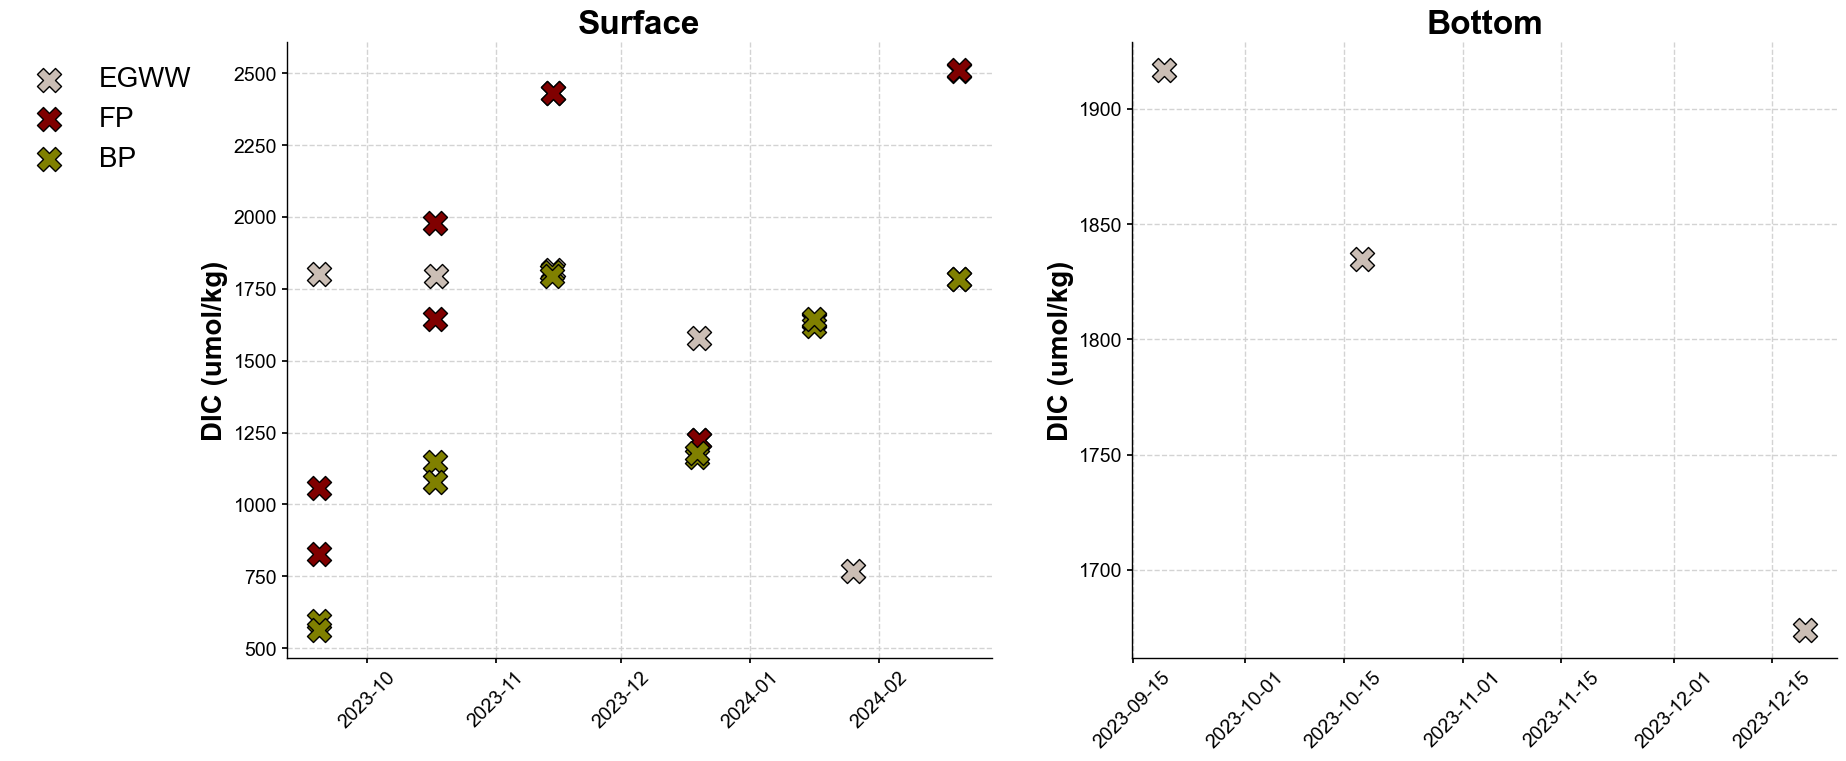

In [199]:


colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'FP': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'BP': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot
markers = {'Bay': 'o', 'Fresh (EPA)': '^', 'Fresh': '*', 'Wastewater': 'X'}


fig, axarr = plt.subplots(ncols = 2, figsize = [20,8])
axarr = axarr.flatten()
var = 'DIC (umol/kg)'

for name in dfwaste['Location'].unique():
    dat = dfwaste[dfwaste['Location'] == name]
    surf = dat[dat['depth'] == 'surface']
    bott = dat[dat['depth'] == 'bottom']
    cat = dat['Category'].unique()
    axarr[0].scatter(surf['Time'],surf[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    axarr[1].scatter(bott['Time'],bott[var], 
                     facecolors = colors[name], edgecolors = 'k',
                     marker = markers[cat.item()], s = 300, label = name)
    
axarr[0].legend(bbox_to_anchor=(-0.1, 1), fontsize = 20)

for ax in axarr:
    # ax.xaxis.set_major_formatter(dtFmt) 
    ax.set_ylabel(var, fontsize = 20, fontweight = 'bold')
    # ax.set_ylim([5,9])
    ax.tick_params('x', labelsize = 14, labelrotation = 45)
    ax.tick_params('y', labelsize = 14)
axarr[0].set_title('Surface', fontsize = 24, fontweight = 'bold')
axarr[1].set_title('Bottom', fontsize = 24, fontweight = 'bold')
# fig.savefig('DICwaste.png', bbox_inches='tight')

In [365]:
# dat['Category']
dfs['Category'].reset_index()['Category']

0            Fresh
1      Fresh (EPA)
2      Fresh (EPA)
3      Fresh (EPA)
4      Fresh (EPA)
          ...     
101            Bay
102            Bay
103            Bay
104            Bay
105            Bay
Name: Category, Length: 106, dtype: object

# Salinity
## Pimenta Data

In [205]:
pimenta = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/Pimenta.csv')
pimenta = pimenta.dropna()
pimenta = pimenta.reset_index(drop = True)
pimenta

,Unnamed: 0,station,datetimeUTC,nomDate,DEP.m,layer,SAL.ppt,degC,DO.mg.L,DOpct,pH.nbs,dic.umkg.apollo,alk.both
0,745,BETS Station 4,2017-01-19 16:04:25,2017-01-19,1.0,surface,27.90,3.75,12.65,116.5,8.19,1767.74,1965.66
1,746,BETS Station 4,2017-01-19 16:04:25,2017-01-19,5.5,mid,30.24,3.82,12.06,112.1,8.12,1875.88,2070.31
2,747,BETS Station 4,2017-01-19 16:04:25,2017-01-19,10.5,bottom,30.92,4.05,11.40,107.1,8.06,1924.06,2099.20
3,748,BETS Station 5,2017-01-19 13:57:02,2017-01-19,1.0,surface,30.78,3.83,11.56,108.2,7.81,1912.19,2094.71
4,749,BETS Station 5,2017-01-19 13:57:02,2017-01-19,7.4,mid,31.64,4.47,11.03,105.3,7.79,1955.46,2120.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,1537,BETS Station 3,2019-11-20 15:25:00,2019-11-19,2.6,mid,29.02,7.57,9.26,93.6,7.84,1883.29,1980.25
628,1538,BETS Station 3,2019-11-20 15:25:00,2019-11-19,4.8,bottom,29.73,8.43,8.97,92.6,7.83,1897.92,1993.05
629,1545,BETS Station 6,2019-11-20 13:49:00,2019-11-19,1.0,surface,30.10,8.71,9.27,96.6,7.64,1940.22,2042.65
630,1546,BETS Station 6,2019-11-20 13:49:00,2019-11-19,5.3,mid,30.22,8.80,9.13,95.6,7.66,1922.42,2043.40


In [206]:
pimenta = pimenta[['station', 'datetimeUTC', 'layer', 'SAL.ppt', 'degC', 'DO.mg.L', 'pH.nbs', 'dic.umkg.apollo','alk.both']]
pimenta = pimenta.rename(columns = {'alk.both': 'TA', 'dic.umkg.apollo': 'DIC', 'datetimeUTC': 'Time', 
                          'layer': 'depth', 'SAL.ppt': 'Salinity', 'pH.nbs': 'pH [NBS]',
                          'degC': 'Temperature', 'DO.mg.L': 'DO [mg/L]'})
pimenta

,station,Time,depth,Salinity,Temperature,DO [mg/L],pH [NBS],DIC,TA
0,BETS Station 4,2017-01-19 16:04:25,surface,27.90,3.75,12.65,8.19,1767.74,1965.66
1,BETS Station 4,2017-01-19 16:04:25,mid,30.24,3.82,12.06,8.12,1875.88,2070.31
2,BETS Station 4,2017-01-19 16:04:25,bottom,30.92,4.05,11.40,8.06,1924.06,2099.20
3,BETS Station 5,2017-01-19 13:57:02,surface,30.78,3.83,11.56,7.81,1912.19,2094.71
4,BETS Station 5,2017-01-19 13:57:02,mid,31.64,4.47,11.03,7.79,1955.46,2120.92
...,...,...,...,...,...,...,...,...,...
627,BETS Station 3,2019-11-20 15:25:00,mid,29.02,7.57,9.26,7.84,1883.29,1980.25
628,BETS Station 3,2019-11-20 15:25:00,bottom,29.73,8.43,8.97,7.83,1897.92,1993.05
629,BETS Station 6,2019-11-20 13:49:00,surface,30.10,8.71,9.27,7.64,1940.22,2042.65
630,BETS Station 6,2019-11-20 13:49:00,mid,30.22,8.80,9.13,7.66,1922.42,2043.40


## Mess with our data
* Take EGWW out of bay/fresh samples so no duplicate
* concatenate bay/fresh and wastewater samples
* subset data into very fresh samples (S ≤ 3; `dfS`) and everything else (S > 3; `dfs`)
* sort subsetted data other poly model will be messed up

In [209]:
dfout = dfout[dfout['Location'] != 'EGWW'].reset_index()

In [211]:
DF = pd.concat([dfout,dfwaste])
DF = DF.reset_index()
DF

,level_0,index,Sample,Time,Location,depth,Category,Salinity,In Situ Temperature,DIC (umol/kg),TA (umol/kg),pH,pCO2,fCO2,Ω
0,0,0.0,PLT 4/28/22 A,2022-04-28 11:30:00,PLT,surface,Bay,29.480,10.400,1893.800902,2037.524946,8.052270,369.496477,368.081301,1.639099
1,1,1.0,PLT 4/28/22 B,2022-04-28 11:30:00,PLT,surface,Bay,29.480,10.400,1893.793216,2037.118191,8.051216,370.434636,369.015867,1.635310
2,2,2.0,PLT 5/9/22 surf A,2022-05-09 11:30:00,PLT,surface,Bay,29.420,10.970,1946.599760,2034.019064,7.872654,583.645244,581.426259,1.157688
3,3,3.0,PLT 5/9/22 surf B,2022-05-09 11:30:00,PLT,surface,Bay,29.420,10.970,1917.494827,2035.302901,7.969078,457.271877,455.533357,1.414052
4,4,4.0,PLT 5/22/22 bottom,2022-05-22 11:30:00,PLT,bottom,Bay,30.620,15.740,1938.168218,2094.161828,7.976161,455.715306,454.085023,1.822445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,28,NaN,FP1 2/20,2024-02-20 05:00:00,FP,surface,Wastewater,0.489,NaN,2508.748282,2060.288997,6.856989,9984.490608,9948.435934,0.031340
178,29,NaN,FP2 2/20,2024-02-20 05:00:00,FP,surface,Wastewater,0.487,NaN,2512.056751,2059.000281,6.852402,10084.979941,10048.562393,0.030924
179,30,NaN,BP1 2/20,2024-02-20 05:00:00,BP,surface,Wastewater,0.300,NaN,1784.778868,1028.982106,6.335570,16679.291439,16619.061385,0.003568
180,31,NaN,BP2 2/20,2024-02-20 05:00:00,BP,surface,Wastewater,0.300,NaN,1785.780427,1026.588379,6.332622,16754.030337,16693.530395,0.003536


In [325]:
dfs = DF[DF['Salinity'] > 3]
dfs = dfs.sort_values(by=['Salinity'])
dfS = DF[DF['Salinity'] <= 3]
dfS = dfS.sort_values(by=['Salinity'])

## Functions for linear model and polynomial model (order 4)

In [326]:
def linear_model(x,y):
    x = np.asarray(x).reshape(-1,1)
    regression_model = LinearRegression()
    regression_model.fit(x,y)
    y_predicted = regression_model.predict(x)
    mse=mean_squared_error(y,y_predicted)
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    return y_predicted, lbl

def poly_model(x,y):
    x = np.asarray(x).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    pr = PolynomialFeatures(degree = 4)
    X_poly = pr.fit_transform(x)
    lr_2 = LinearRegression()
    lr_2.fit(X_poly, y)
    y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
    cs = lr_2.coef_
    c0 = "%.3f" % cs[0,0]
    c1 = "%.3f" % cs[0,1]
    c2 = "%.3f" % cs[0,2]
    c3 = "%.3f" % cs[0,3]
    c4 = "%.3f" % cs[0,4]
    # c5 = "%.3f" % cs[0,5]
    r2 = r2_score(y, y_pred_poly)
    mse=mean_squared_error(y,y_pred_poly)
    rmse = np.sqrt(mean_squared_error(y, y_pred_poly))
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    lbl = 'Y = ' + c0 + ' + ' + c1 + 'x + ' + c2 + 'x$^2$\n + ' + c3 + 'x$^3$ + ' + c4 + 'x$^4$\nR$^2$ = ' + R2 + '\nRMSE = ' + RMSE
    # lbl = 'Y = ' + c0 + ' + ' + c1 + 'x + ' + c2 + 'x$^2$ + ' + c3 + 'x$^3$ + ' + c4 + 'x$^4$ + ' + c5 + 'x$^5$\n R$^2$ = ' + R2
    return y_pred_poly, lbl

In [294]:
lime = '#bfef45'
mint = '#aaffc3'
red = '#e2062c'
green = '#3cb44b'
purple = '#911eb4'
cyan = '#0abab5'
pink = '#ff6289'
lav = '#dcbeff'
apricot = '#ffd8b1'

## Plot
### S vs DIC and TA for all samples (including Pimenta)

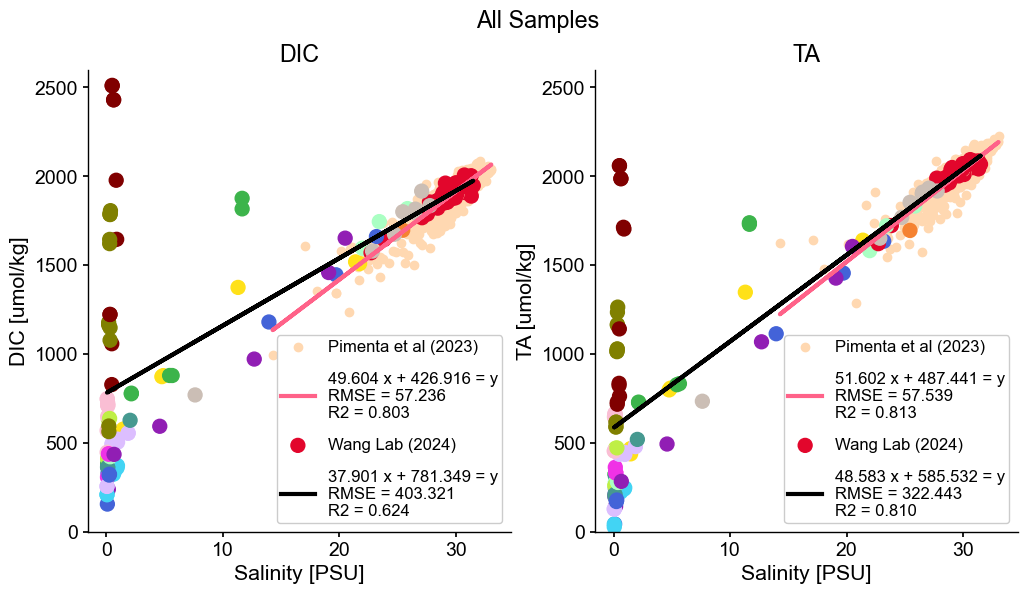

In [384]:
fig, axs = plt.subplots(ncols = 2, figsize = [12,6])
axs = axs.flatten()
axDIC = axs[0]
axTA = axs[1]

# # PIMENTA DATA
S = pimenta['Salinity']
DIC = pimenta['DIC']
TA = pimenta['TA']

# DIC
axDIC.scatter(S,DIC, label = 'Pimenta et al (2023)', color = apricot)
Y, lbl1 = linear_model(S,DIC)
axDIC.plot(S,Y, color = pink, label = lbl1, lw = 3)

# TA
axTA.scatter(S,TA, label = 'Pimenta et al (2023)', color = apricot)
Y, lbl2 = linear_model(S,TA)
axTA.plot(S,Y, color = pink, label = lbl2, lw = 3)

# # WANG DATA
S = DF['Salinity']
DIC = DF['DIC (umol/kg)']
TA = DF['TA (umol/kg)']

# DIC
axDIC.scatter(S,DIC, label = 'Wang Lab (2024)', color=[ colors[i] for i in DF['Location'] ], s = 100 )
Y, lbl = linear_model(S,DIC)
axDIC.plot(S,Y, color = 'k', label = lbl, lw = 3)

# TA
axTA.scatter(S,TA, label = 'Wang Lab (2024)', color=[ colors[i] for i in DF['Location'] ], s = 100 )
Y, lbl = linear_model(S,TA)
axTA.plot(S,Y, color = 'k', label = lbl, lw = 3)

# Formatting
fig.suptitle('All Samples')
axDIC.set_ylabel('DIC [umol/kg]')
axDIC.set_title('DIC')
axTA.set_title('TA')
axTA.set_ylabel('TA [umol/kg]')

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Salinity [PSU]')
    ax.set_ylim([0,2600])
    ax.legend(loc = 'lower right', frameon = 1,labelspacing = 1, borderpad = 0.25, fontsize = 12,framealpha = 1, facecolor = 'white') 
# fig.savefig('S_DIC_TA_all_wPimenta.png', bbox_inches='tight')

### S vs DIC and TA for S > 3

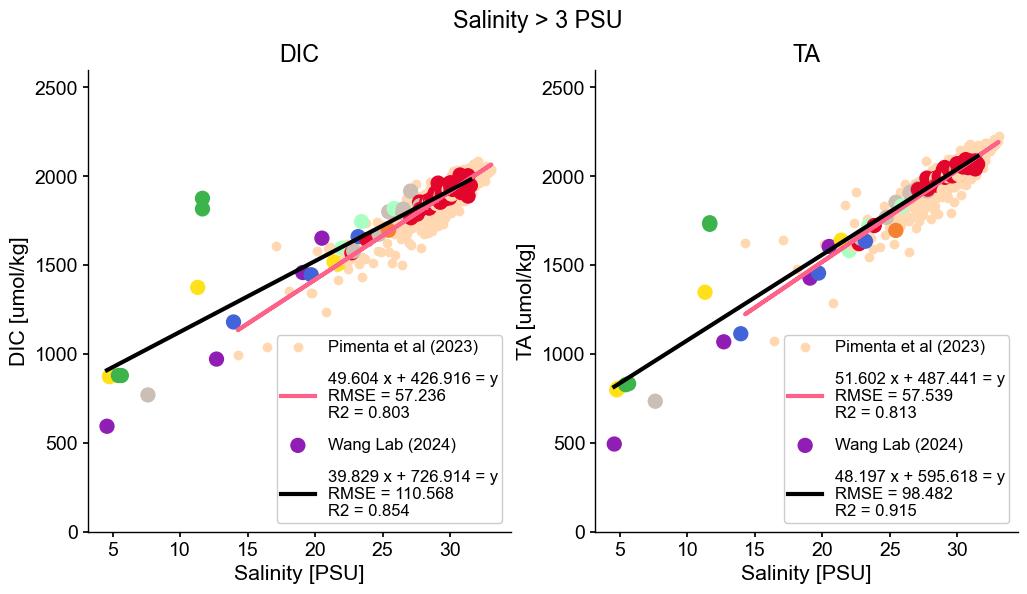

In [381]:
fig, axs = plt.subplots(ncols = 2, figsize = [12,6])
axs = axs.flatten()
axDIC = axs[0]
axTA = axs[1]

# # PIMENTA DATA
S = pimenta['Salinity']
DIC = pimenta['DIC']
TA = pimenta['TA']

# DIC
axDIC.scatter(S,DIC, label = 'Pimenta et al (2023)', color = apricot)
Y, lbl = linear_model(S,DIC)
axDIC.plot(S,Y, color = pink, label = lbl, lw = 3)

# TA
axTA.scatter(S,TA, label = 'Pimenta et al (2023)', color = apricot)
Y, lbl = linear_model(S,TA)
axTA.plot(S,Y, color = pink, label = lbl, lw = 3)

# # WANG DATA
S = dfs['Salinity']
DIC = dfs['DIC (umol/kg)']
TA = dfs['TA (umol/kg)']
T = dfs['Category'].reset_index()['Category']
colors = {'PLT': '#e2062c', #red
          'Festival Pier (EPA)': '#3cb44b', #green
          'Pawtuxet Cove (EPA)': '#ffe119', #yellow
          'Hunt River': '#4363d8', #blue
          'Rocky Hill': '#f58231', #orange
          'Palmer River': '#911eb4', #purple 
          'Pawcatuck River': '#42d4f4', #cyan
          'Woonasquatucket River': '#f032e6', #magenta
          'Ten Mile River': '#bfef45', #lime
          'CT River': '#fabed4', #pink
          'Taunton River': '#469990', #teal
          'Thames River': '#dcbeff', #lavender
          'brown': '#9A6324', #brown
          'EGWW': '#cbbeb5', #beige
          'FP': '#800000', #maroon
          'Hardig Brook': '#aaffc3', #mint
          'BP': '#808000', #olive
          'GB': '#ffd8b1'}  #apricot

# DIC
axDIC.scatter(S,DIC, label = 'Wang Lab (2024)', color=[ colors[i] for i in dfs['Location'] ], s = 100 )
Y, lbl = linear_model(S,DIC)
axDIC.plot(S,Y, color = 'k', label = lbl, lw = 3)

# TA
axTA.scatter(S,TA, label = 'Wang Lab (2024)', color=[ colors[i] for i in dfs['Location'] ], s = 100 )
Y, lbl = linear_model(S,TA)
axTA.plot(S,Y, color = 'k', label = lbl, lw = 3)

# Formatting
fig.suptitle('Salinity > 3 PSU')
axDIC.set_ylabel('DIC [umol/kg]')
axDIC.set_title('DIC')
axTA.set_title('TA')
axTA.set_ylabel('TA [umol/kg]')

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Salinity [PSU]')
    ax.set_ylim([0,2600])
    ax.legend(loc = 'lower right', frameon = 1,labelspacing = 1, borderpad = 0.25, fontsize = 12,framealpha = 1, facecolor = 'white') 
fig.savefig('S_DIC_TA_Sgt3.png', bbox_inches='tight')

### S vs DIC and TA for S ≤ 3

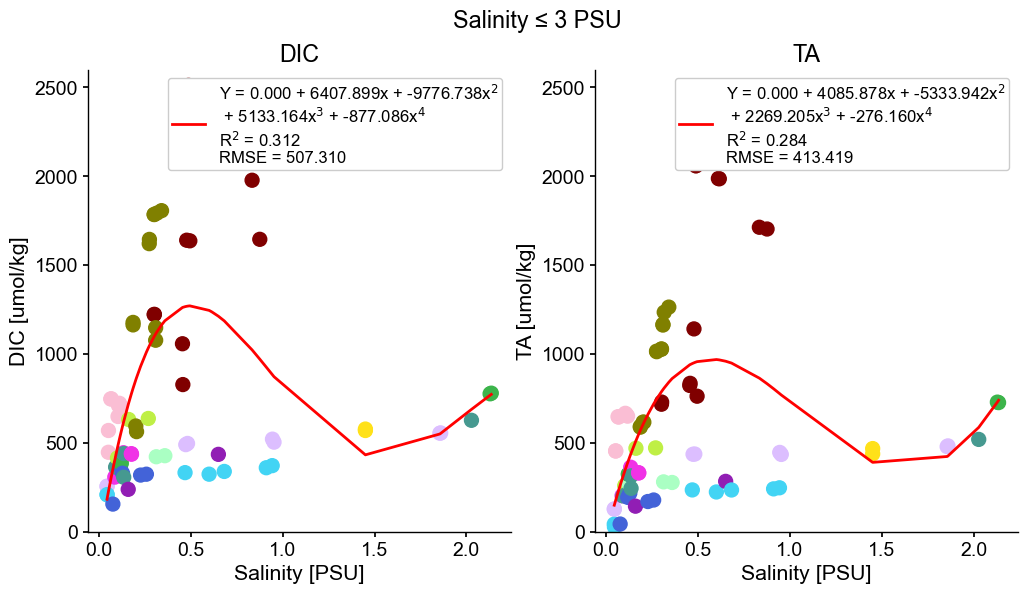

In [383]:
fig, axs = plt.subplots(ncols = 2, figsize = [12,6])
axs = axs.flatten()
axDIC = axs[0]
axTA = axs[1]

S = dfS['Salinity']
DIC = dfS['DIC (umol/kg)']
TA = dfS['TA (umol/kg)']

# DIC
axDIC.scatter(S,DIC, color=[ colors[i] for i in dfS['Location'] ], s = 100 )
x = dfS['Salinity']
y = dfS['DIC (umol/kg)']
Y, lbl = poly_model(x,y)
axDIC.plot(x,Y,label= lbl, color = 'red')

# TA
axTA.scatter(S,TA, color=[ colors[i] for i in dfS['Location'] ], s = 100 )
x = dfS['Salinity']
y = dfS['TA (umol/kg)']
Y, lbl = poly_model(x,y)
axTA.plot(S,Y, color = 'red', label = lbl)

# Formatting
fig.suptitle('Salinity ≤ 3 PSU')
axDIC.set_ylabel('DIC [umol/kg]')
axDIC.set_title('DIC')
axTA.set_title('TA')
axTA.set_ylabel('TA [umol/kg]')

for ax in axs:
    ax.grid(False)
    ax.set_xlabel('Salinity [PSU]')
    ax.set_ylim([0,2600])
    ax.legend(loc = 'upper right', frameon = 1,labelspacing = 1, borderpad = 0.25, fontsize = 12,framealpha = 1, facecolor = 'white') 
fig.savefig('S_DIC_TA_Sle3.png', bbox_inches='tight')